In [1]:
import models.dcgan as dcgan
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

class Config:
  def __init__(self,num_layers, output, kernel, stride, padding):
    self.num_layers = num_layers
    self.output = output
    self.kernel = kernel
    self.stride = stride
    self.padding = padding



num_layers = 3
g_output = [100,128,64,32,1]
g_kernel = [4,3,4,4]
g_stride = [1,2,2,2]
g_padding = [0,1,1,1]


d_output = [1,32,64,128,1]
d_kernel = [4,4,3,4]
d_stride = [2,2,2,2]
d_padding = [1,1,1,0]


g_config = Config(num_layers,g_output, g_kernel, g_stride, g_padding)
d_config = Config(num_layers,d_output, d_kernel, d_stride, d_padding)
generator = dcgan.Generator(g_config)
discriminator = dcgan.Discriminator(d_config)

In [2]:
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find("Conv") != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

In [3]:
generator.apply(weights_init)
discriminator.apply(weights_init)

Discriminator(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(128, 1, kernel_size=(4, 4), stride=(2, 2))
    (10): Sigmoid()
  )
)

In [4]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.MNIST("MNIST_data/", download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

testset = datasets.MNIST("MNIST_data/", download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=True)

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer_gen = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_dis = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

criterion = nn.BCELoss()
generator.to(device)
discriminator.to(device)
criterion.to(device)

num_epochs = 10

save_path = 'training_weights/'
for epoch in range(num_epochs):
  loss_d = 0.0
  loss_g = 0.0

  for i, (images, labels) in enumerate(trainloader):
    images = images.to(device)

    discriminator.zero_grad()

    real_labels = torch.full((images.size(0), ), 1.0).to(device)
    d_real = discriminator(images).view(-1)
    d_loss_real = criterion(d_real, real_labels)
    d_loss_real.backward()

    noise = torch.randn((images.size(0), 100, 1, 1)).to(device)
    fake_images = generator(noise)

    fake_labels = torch.full((images.size(0), ), 0.0).to(device)
    d_fake = discriminator(fake_images.detach()).view(-1)
    d_loss_fake = criterion(d_fake, fake_labels)
    d_loss_fake.backward()

    d_loss = d_loss_real + d_loss_fake
    optimizer_dis.step()

    generator.zero_grad()

    d_fake = discriminator(fake_images).view(-1)
    g_loss = criterion(d_fake, real_labels)
    g_loss.backward()

    optimizer_gen.step()

    if i % 100 == 0:
      print(f"Epoch [{epoch}/{num_epochs}], Batch [{i}], LOSS_D: {d_loss}, LOSS_G: {g_loss}")
torch.save(generator.state_dict(), save_path + 'generator.pth')
torch.save(discriminator.state_dict(), save_path + 'discriminator.pth')

Epoch [0/10], Batch [0], LOSS_D: 1.5921059846878052, LOSS_G: 0.8424785137176514
Epoch [0/10], Batch [100], LOSS_D: 0.13122907280921936, LOSS_G: 4.490449905395508
Epoch [0/10], Batch [200], LOSS_D: 0.13807520270347595, LOSS_G: 3.4792284965515137
Epoch [0/10], Batch [300], LOSS_D: 0.10802778601646423, LOSS_G: 3.638218402862549
Epoch [0/10], Batch [400], LOSS_D: 0.05907673016190529, LOSS_G: 4.051634788513184
Epoch [1/10], Batch [0], LOSS_D: 0.10568481683731079, LOSS_G: 3.8387503623962402


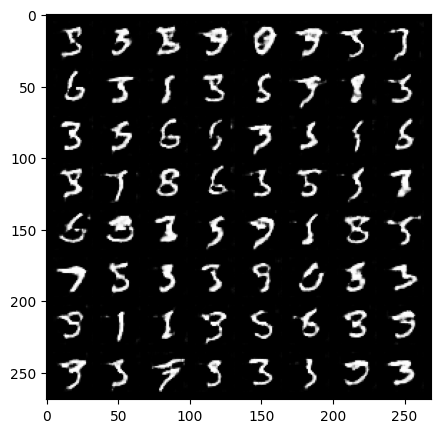

In [ ]:
import numpy as np
import torchvision.utils as vutils
ig = plt.figure(figsize=(5, 5))
rand_noise = torch.rand((64, 100, 1, 1))
out = vutils.make_grid(generator(rand_noise.to(device)).cpu().detach(), padding=5, normalize=True)
plt.imshow(np.transpose(out.numpy(), (1, 2, 0)), cmap="gray")

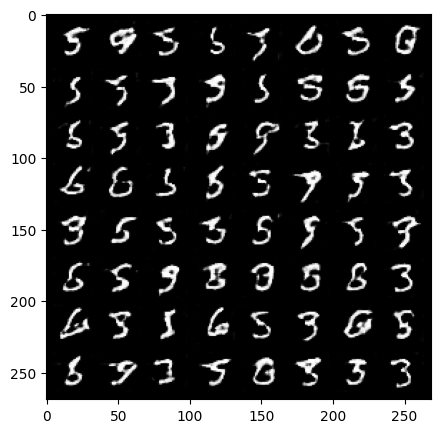

In [ ]:
import numpy as np
import torchvision.utils as vutils
ig = plt.figure(figsize=(5, 5))
rand_noise = torch.rand((64, 100, 1, 1))
out = vutils.make_grid(generator(rand_noise.to(device)).detach(), padding=5, normalize=True)
plt.imshow(np.transpose(out.numpy(), (1, 2, 0)), cmap="gray")

The numbers are mostly recognizebale after only 10 epochs the results would been better with more epochs or maybe with changing some parameters

In [5]:
class CGenerator(nn.Module):
    def __init__(self, config):
        super(CGenerator, self).__init__()
        layers = []

        layers.append(nn.Embedding(config.num_classes, config.embedding))
        for i in range(config.num_layers):
            if i == 0:
                input_dim = config.output[i] + config.embedding
            else:
                input_dim = config.output[i]

            layers.append(nn.ConvTranspose2d(input_dim, config.output[i + 1], config.kernel[i],
                                        config.stride[i], config.padding[i], bias=False))
            layers.append(nn.BatchNorm2d(config.output[i + 1]))
            layers.append(nn.ReLU(True))

        layers.append(nn.ConvTranspose2d(config.output[-2], config.output[-1], config.kernel[-1],
                                        config.stride[-1], config.padding[-1], bias=False))
        layers.append(nn.Tanh())

        self.network = nn.Sequential(*layers)

    def forward(self, x, labels):
      x = torch.cat((x, self.embedding(labels)), dim=1)
      return self.network(x)

In [6]:
class CGenerator(nn.Module):
    def __init__(self, config):
        super(CGenerator, self).__init__()
        self.embedding = nn.Embedding(config.num_classes, config.embedding)
        layers = []
        self.input = config.output[0] 
        
        for i in range(config.num_layers):
            if i == 0:
                input_dim = config.output[i] + config.embedding
            else:
                input_dim = config.output[i]

            layers.append(nn.ConvTranspose2d(input_dim, config.output[i + 1], config.kernel[i],
                                        config.stride[i], config.padding[i], bias=False))
            layers.append(nn.BatchNorm2d(config.output[i + 1]))
            layers.append(nn.ReLU(True))

        layers.append(nn.ConvTranspose2d(config.output[-2], config.output[-1], config.kernel[-1],
                                        config.stride[-1], config.padding[-1], bias=False))
        layers.append(nn.Tanh())

        self.network = nn.Sequential(*layers)

    def forward(self, x, labels):
      embedded_labels = self.embedding(labels).unsqueeze(2).unsqueeze(3)
      embedded_labels = embedded_labels.expand(x.size(0), -1, x.size(2), x.size(3))
      x = torch.cat((x, embedded_labels), dim=1)
      x = self.network(x)
      return x


class CDiscriminator(nn.Module):
  def __init__(self, config):
    super(CDiscriminator, self).__init__()
    self.embedding = nn.Embedding(config.num_classes, config.embedding)
    self.input = config.output[0] 
    layers = []
    for i in range(config.num_layers):
      if i == 0:
        input_dim = config.output[i] + config.embedding
      else:
        input_dim = config.output[i]
      layers.append(nn.Conv2d(input_dim, config.output[i + 1], config.kernel[i],
                                        config.stride[i], config.padding[i]))
      layers.append(nn.BatchNorm2d(config.output[i + 1]))
      layers.append(nn.ReLU(True))

    layers.append(nn.Conv2d(config.output[-2], config.output[-1], config.kernel[-1],
                                        config.stride[-1], config.padding[-1]))
                                        
    layers.append(nn.Sigmoid())

    self.network = nn.Sequential(*layers)

  def forward(self, x, labels):
    embedded_labels = self.embedding(labels).unsqueeze(2).unsqueeze(3)
    embedded_labels = embedded_labels.expand(x.size(0), -1, x.size(2), x.size(3))
    x = torch.cat((x, embedded_labels), dim=1)
    x = self.network(x)
    return x.squeeze()

    




In [8]:
import models.dcgan as dcgan
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

class Config:
  def __init__(self,num_layers, output, kernel, stride, padding, num_classes, embedding):
    self.num_layers = num_layers
    self.output = output
    self.kernel = kernel
    self.stride = stride
    self.padding = padding
    self.num_classes = num_classes
    self.embedding = embedding



num_layers = 3
num_classes = 10
embedding = 10

g_output = [100,128,64,32,1]
g_kernel = [4,3,4,4]
g_stride = [1,2,2,2]
g_padding = [0,1,1,1]


d_output = [1,32,64,128,1]
d_kernel = [4,4,3,4]
d_stride = [2,2,2,2]
d_padding = [1,1,1,0]


g_config = Config(num_layers,g_output, g_kernel, g_stride, g_padding, num_classes, embedding)
d_config = Config(num_layers,d_output, d_kernel, d_stride, d_padding, num_classes, embedding)
#Cgenerator = dcgan.CGenerator(g_config)
#Cdiscriminator = dcgan.CDiscriminator(g_config)
Cgenerator = CGenerator(g_config)
Cdiscriminator = CDiscriminator(d_config)

In [9]:
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find("Conv") != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

Cgenerator.apply(weights_init)
Cdiscriminator.apply(weights_init)

CDiscriminator(
  (embedding): Embedding(10, 10)
  (network): Sequential(
    (0): Conv2d(11, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(128, 1, kernel_size=(4, 4), stride=(2, 2))
    (10): Sigmoid()
  )
)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer_gen = torch.optim.Adam(Cgenerator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_dis = torch.optim.Adam(Cdiscriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

criterion = nn.BCELoss()
Cgenerator.to(device)
Cdiscriminator.to(device)
criterion.to(device)

num_epochs = 10

save_path = 'training_weights/'

for epoch in range(num_epochs):
  loss_d = 0.0
  loss_g = 0.0

  for i, (images, labels) in enumerate(trainloader):
    images = images.to(device)
    labels = labels.to(device)

    Cdiscriminator.zero_grad()

    real_labels = torch.full((images.size(0), ), 1.0).to(device)
    d_real = Cdiscriminator(images, labels)
    d_loss_real = criterion(d_real, real_labels)
    d_loss_real.backward()

    noise = torch.randn((images.size(0), 100, 1, 1)).to(device)
    fake_images = Cgenerator(noise, labels)
    fake_labels = torch.full((images.size(0), ), 0.0).to(device)
    d_fake = Cdiscriminator(fake_images.detach(), labels).view(-1)
    d_loss_fake = criterion(d_fake, fake_labels)
    d_loss_fake.backward()

    d_loss = d_loss_real + d_loss_fake
    optimizer_dis.step()

    Cgenerator.zero_grad()

    d_fake = Cdiscriminator(fake_images, labels)
    g_loss = criterion(d_fake, real_labels)
    g_loss.backward()

    optimizer_gen.step()

    if i % 100 == 0:
      print(f"Epoch [{epoch}/{num_epochs}], Batch [{i}], LOSS_D: {d_loss}, LOSS_G: {g_loss}")

torch.save(Cgenerator.state_dict(), save_path + 'Cgenerator.pth')
torch.save(Cdiscriminator.state_dict(), save_path + 'Cdiscriminator.pth')

Epoch [0/10], Batch [0], LOSS_D: 1.4413946866989136, LOSS_G: 0.8800963163375854
Epoch [0/10], Batch [100], LOSS_D: 0.06625910848379135, LOSS_G: 4.245228290557861
Epoch [0/10], Batch [200], LOSS_D: 0.26284435391426086, LOSS_G: 2.8469080924987793
Epoch [0/10], Batch [300], LOSS_D: 0.4037344455718994, LOSS_G: 3.3279647827148438
Epoch [0/10], Batch [400], LOSS_D: 0.680057168006897, LOSS_G: 2.665132761001587
Epoch [1/10], Batch [0], LOSS_D: 0.9581468105316162, LOSS_G: 1.2989983558654785
Epoch [1/10], Batch [100], LOSS_D: 0.7933942675590515, LOSS_G: 1.4203826189041138
Epoch [1/10], Batch [200], LOSS_D: 0.6986730098724365, LOSS_G: 1.523841142654419
Epoch [1/10], Batch [300], LOSS_D: 0.7648524045944214, LOSS_G: 1.8684290647506714
Epoch [1/10], Batch [400], LOSS_D: 0.8085744380950928, LOSS_G: 1.613191843032837
Epoch [2/10], Batch [0], LOSS_D: 0.8343556523323059, LOSS_G: 1.4839857816696167
Epoch [2/10], Batch [100], LOSS_D: 1.0503754615783691, LOSS_G: 2.2539331912994385
Epoch [2/10], Batch [200]

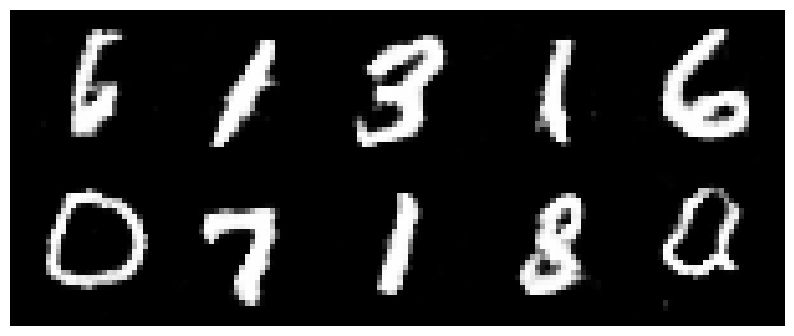

In [ ]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Assuming Cgenerator is your trained generator model

# Set the generator to evaluation mode
Cgenerator.eval()

# Generate random noise and corresponding labels for visualization
num_samples = 10
noise = torch.randn(num_samples, 100, 1, 1).to(device)  # Assuming latent_dim is the size of your latent space
random_labels = torch.randint(0, num_classes, (num_samples,)).to(device)

# Generate images using the trained generator
with torch.no_grad():
    generated_images = Cgenerator(noise, random_labels).cpu()

img_grid = vutils.make_grid(generated_images, nrow=5, padding=2, normalize=True)  
plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(img_grid, (1, 2, 0)))
plt.axis('off')
plt.show()


This are the solutions Condional DCGAN after 10 epochs

Improve overall for both:
- Architecture (its dynamic I could try different depth etc)
- Hyperparameters
- for conditional instead of embedding two separate layers (input and label which get concatenated)